In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as img
import itertools
import pathlib
import warnings
from PIL import Image
from random import randint
warnings.filterwarnings('ignore')
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import keras
from keras import layers, models
import tensorflow as tf
# import tensorflow_addons as tfa
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D,GaussianNoise
from distutils.dir_util import copy_tree, remove_tree
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import regularizers
from keras.regularizers import l2
from keras.optimizers import Adam
import sys, cv2, glob, os, time
from sklearn.utils import shuffle
import re,string
from tensorflow.keras.utils import to_categorical
from nltk.corpus import stopwords
from tensorflow.keras.applications import Xception, VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import DenseNet201
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

2024-05-28 02:53:01.842986: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-28 02:53:01.843091: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-28 02:53:02.083175: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
from sklearn.metrics import f1_score as sk_f1_score


In [3]:
# !pip install Augmentor

In [4]:
# import Augmentor
# p = Augmentor.Pipeline("/content/drive/My Drive/kvasir-dataset-v2/") ### augment class wise samples

In [5]:


import Augmentor
p = Augmentor.Pipeline("/content/drive/My Drive/kvasir-dataset-v2/")

p.rotate(probability=0.8, max_left_rotation=10, max_right_rotation=10)
p.zoom(probability=0.2, min_factor=0.7, max_factor=1.0)
p.flip_left_right(probability=0.7)
p.flip_top_bottom(probability=0.5)
p.random_distortion(probability=0.3,grid_width=2,grid_height=2,magnitude=7)
p.sample(18000)

In [6]:
def get_images(directory):
    Images = []
    Labels = []

    if not directory.endswith('/'):
        directory += '/'

    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)

        if os.path.isdir(label_path):
            for image_file in os.listdir(label_path):
                image_path = os.path.join(label_path, image_file)

                try:
                    image = cv2.imread(image_path)
                    if image is not None:
                        image = cv2.resize(image, (224, 224))
                        Images.append(image)
                        Labels.append(label)
                    else:
                        print(f"Warning: {image_path} could not be read as an image.")
                except Exception as e:
                    print(f"Error reading {image_path}: {e}")

    return shuffle(Images, Labels, random_state=817328462)

In [7]:
Images, Labels = get_images("/kaggle/input/kvasir/kvasir-dataset-v2")

Images = np.array(Images)
Labels = np.array(Labels)

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Images, Labels, test_size=0.1, random_state = 42,shuffle=True,stratify = Labels)

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Images, Labels, test_size=0.1, random_state = 42,shuffle=True,stratify = Labels)

X_train = X_train.reshape((len(X_train), 224,224,3))
X_test = X_test.reshape((len(X_test), 224,224,3))

label_encoder = LabelEncoder()

Y_train = np.array(label_encoder.fit_transform(y_train))
Y_test = np.array(label_encoder.fit_transform(y_test))
y_test = to_categorical(Y_test)


X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7200, 224, 224, 3), (7200, 8), (800, 224, 224, 3), (800, 8))

In [10]:
def f1_score(y_true, y_pred):
    return sk_f1_score(y_true, y_pred, average='weighted')

from sklearn.metrics import f1_score as sk_f1_score

def f1_score(y_true, y_pred):
    return sk_f1_score(y_true, y_pred, average='weighted')


Efficient Gastro

In [11]:
base_model = tf.keras.applications.EfficientNetB1(weights='imagenet', input_shape=(224,224,3), include_top=False)

for layer in base_model.layers:
    layer.trainable=False
model = Sequential()
model.add(base_model)
model.add(Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(Conv2D(512,kernel_size=(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(GaussianNoise(0.25))
model.add(GlobalAveragePooling2D())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.35))
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(GaussianNoise(0.25))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=["accuracy",'Precision','Recall', 'AUC'])
model.summary()

27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb1 (Functional)     │ ?                      │     6,575,239 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise (GaussianNoise)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_1                │ ?                      │   0 (unbuilt) │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,575,239 (25.08 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 6,575,239 (25.08 MB)

In [12]:
hist = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=25, batch_size=64, verbose=1)

Epoch 1/25
  1/113 ━━━━━━━━━━━━━━━━━━━━ 2:06:35 68s/step - AUC: 0.4432 - Precision: 0.0455 - Recall: 0.0156 - accuracy: 0.0781 - loss: 2.9523

I0000 00:00:1716865076.840257     107 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716865076.920705     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - AUC: 0.8774 - Precision: 0.6515 - Recall: 0.4804 - accuracy: 0.5676 - loss: 1.2531

W0000 00:00:1716865140.755835     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


113/113 ━━━━━━━━━━━━━━━━━━━━ 138s 625ms/step - AUC: 0.8780 - Precision: 0.6525 - Recall: 0.4818 - accuracy: 0.5687 - loss: 1.2496 - val_AUC: 0.9765 - val_Precision: 0.8703 - val_Recall: 0.6125 - val_accuracy: 0.7837 - val_loss: 0.7032
Epoch 2/25
113/113 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - AUC: 0.9828 - Precision: 0.8379 - Recall: 0.7877 - accuracy: 0.8160 - loss: 0.4673 - val_AUC: 0.9863 - val_Precision: 0.8447 - val_Recall: 0.7887 - val_accuracy: 0.8225 - val_loss: 0.4341
Epoch 3/25
113/113 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - AUC: 0.9893 - Precision: 0.8840 - Recall: 0.8515 - accuracy: 0.8694 - loss: 0.3531 - val_AUC: 0.9883 - val_Precision: 0.8612 - val_Recall: 0.8300 - val_accuracy: 0.8475 - val_loss: 0.3799
Epoch 4/25
113/113 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - AUC: 0.9927 - Precision: 0.8919 - Recall: 0.8717 - accuracy: 0.8810 - loss: 0.2956 - val_AUC: 0.9854 - val_Precision: 0.8495 - val_Recall: 0.8325 - val_accuracy: 0.8400 - val_loss: 0.4343
Epoch 5/25
113/113 ━━━━━━━━━━━

In [13]:
predict=model.predict(X_test)
classes=np.argmax(predict,axis=1)
rounded_labels=np.argmax(y_test, axis=1)
print(classification_report(rounded_labels,classes))
cnf_matrix=confusion_matrix(rounded_labels,classes)
print(cnf_matrix)
plt.figure(figsize=(12, 8))

25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step
              precision    recall  f1-score   support

           0       0.95      0.79      0.86       100
           1       0.83      0.94      0.88       100
           2       0.73      0.63      0.68       100
           3       0.92      0.95      0.94       100
           4       0.98      0.95      0.96       100
           5       0.68      0.80      0.73       100
           6       0.88      0.92      0.90       100
           7       0.93      0.89      0.91       100

    accuracy                           0.86       800
   macro avg       0.86      0.86      0.86       800
weighted avg       0.86      0.86      0.86       800

[[79 18  0  0  0  0  2  1]
 [ 4 94  0  1  0  0  1  0]
 [ 0  0 63  0  1 36  0  0]
 [ 0  0  0 95  0  0  2  3]
 [ 0  0  2  0 95  2  0  1]
 [ 0  0 20  0  0 80  0  0]
 [ 0  1  0  4  1  0 92  2]
 [ 0  0  1  3  0  0  7 89]]


<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


<Figure size 640x480 with 0 Axes>

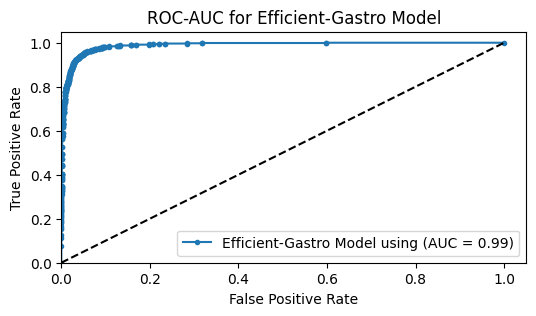

Whole AUC (Micro-average AUC): 0.99


In [14]:
class_labels = [0, 1, 2, 3, 4, 5, 6, 7]

y_test_bin = label_binarize(y_test, classes=class_labels)

y_pred_prob = model.predict(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_labels)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
plt.figure(figsize=(6, 3))
plt.plot(fpr["micro"], tpr["micro"], marker='o', markersize=3, linestyle='-', label='Efficient-Gastro Model using (AUC = {:.2f})'.format(roc_auc["micro"]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC for Efficient-Gastro Model')
plt.legend(loc="lower right")
plt.show()

print("Whole AUC (Micro-average AUC): {:.2f}".format(roc_auc["micro"]))

VGG19

In [15]:
pretrained_model=VGG19(input_shape = (224, 224, 3),
                        include_top = False,
                        weights = 'imagenet')

for layer in pretrained_model.layers:
     layer.trainable = False


last_layer = pretrained_model.get_layer('block5_pool')
prev_layer = pretrained_model.get_layer('block5_conv3')
last_output = last_layer(prev_layer.output)

last_output= last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(8, activation='softmax')(x)

model_vgg = Model(pretrained_model.input, x)

model_vgg.compile(optimizer = "Adam",
              loss = 'categorical_crossentropy',
              metrics=["accuracy",'Precision','Recall', 'AUC'])
model_vgg.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        33,02

 Total params: 23,302,728 (88.89 MB)

 Trainable params: 3,278,344 (12.51 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [16]:
hist2 = model_vgg.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=25, batch_size=32, verbose=1)

Epoch 1/25
  1/225 ━━━━━━━━━━━━━━━━━━━━ 2:16:06 36s/step - AUC: 0.4814 - Precision: 0.1250 - Recall: 0.1250 - accuracy: 0.1250 - loss: 11.7208

W0000 00:00:1716865485.110749     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - AUC: 0.8113 - Precision: 0.5520 - Recall: 0.5169 - accuracy: 0.5352 - loss: 5.5911

W0000 00:00:1716865521.791939     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


225/225 ━━━━━━━━━━━━━━━━━━━━ 77s 180ms/step - AUC: 0.8117 - Precision: 0.5526 - Recall: 0.5173 - accuracy: 0.5357 - loss: 5.5766 - val_AUC: 0.9752 - val_Precision: 0.8163 - val_Recall: 0.7775 - val_accuracy: 0.8050 - val_loss: 0.5626
Epoch 2/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 39s 172ms/step - AUC: 0.9764 - Precision: 0.8357 - Recall: 0.7848 - accuracy: 0.8125 - loss: 0.5434 - val_AUC: 0.9746 - val_Precision: 0.8368 - val_Recall: 0.7950 - val_accuracy: 0.8138 - val_loss: 0.6167
Epoch 3/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 41s 173ms/step - AUC: 0.9869 - Precision: 0.8891 - Recall: 0.8565 - accuracy: 0.8738 - loss: 0.3892 - val_AUC: 0.9814 - val_Precision: 0.8410 - val_Recall: 0.8000 - val_accuracy: 0.8188 - val_loss: 0.5189
Epoch 4/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 39s 172ms/step - AUC: 0.9922 - Precision: 0.9234 - Recall: 0.9018 - accuracy: 0.9122 - loss: 0.2631 - val_AUC: 0.9791 - val_Precision: 0.8632 - val_Recall: 0.8363 - val_accuracy: 0.8487 - val_loss: 0.5234
Epoch 5/25
225/225 ━━━━━━━━━━━━

In [17]:
predict=model_vgg.predict(X_test)
classes=np.argmax(predict,axis=1)
rounded_labels=np.argmax(y_test, axis=1)
print(classification_report(rounded_labels,classes))
cnf_matrix=confusion_matrix(rounded_labels,classes)
print(cnf_matrix)
plt.figure(figsize=(12, 8))

 2/25 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step 

W0000 00:00:1716866457.679826     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step
              precision    recall  f1-score   support

           0       0.79      0.77      0.78       100
           1       0.81      0.83      0.82       100
           2       0.70      0.85      0.77       100
           3       0.96      0.95      0.95       100
           4       0.98      0.96      0.97       100
           5       0.79      0.65      0.71       100
           6       0.89      0.83      0.86       100
           7       0.90      0.96      0.93       100

    accuracy                           0.85       800
   macro avg       0.85      0.85      0.85       800
weighted avg       0.85      0.85      0.85       800

[[77 20  0  0  0  0  2  1]
 [13 83  0  1  0  0  2  1]
 [ 0  0 85  0  0 15  0  0]
 [ 1  0  0 95  0  0  2  2]
 [ 0  0  2  0 96  2  0  0]
 [ 0  0 33  0  1 65  1  0]
 [ 6  0  1  2  1  0 83  7]
 [ 0  0  0  1  0  0  3 96]]


<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step


<Figure size 640x480 with 0 Axes>

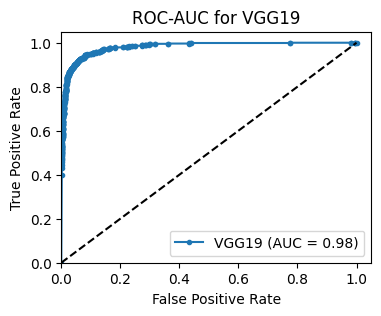

Whole AUC (Micro-average AUC): 0.98


In [18]:
class_labels = [0, 1, 2, 3, 4, 5, 6, 7]

y_test_bin = label_binarize(y_test, classes=class_labels)

y_pred_prob = model_vgg.predict(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_labels)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
plt.figure(figsize=(4, 3))
plt.plot(fpr["micro"], tpr["micro"], marker='o', markersize=3, linestyle='-', label='VGG19 (AUC = {:.2f})'.format(roc_auc["micro"]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC for VGG19')
plt.legend(loc="lower right")
plt.show()

print("Whole AUC (Micro-average AUC): {:.2f}".format(roc_auc["micro"]))

Conv2d

In [19]:
model_cnn = models.Sequential()
model_cnn.add(layers.Rescaling(1./255, input_shape=(224, 224, 3)))

model_cnn.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer="he_normal"))
model_cnn.add(layers.BatchNormalization())
model_cnn.add(layers.MaxPooling2D((2, 2)))

model_cnn.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer="he_normal"))
model_cnn.add(layers.BatchNormalization())
model_cnn.add(layers.MaxPooling2D((2, 2)))

model_cnn.add(layers.Dropout(0.5))

model_cnn.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_initializer="he_normal"))
model_cnn.add(layers.BatchNormalization())
model_cnn.add(layers.MaxPooling2D((2, 2)))

model_cnn.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu', kernel_initializer="he_normal"))
model_cnn.add(layers.BatchNormalization())
model_cnn.add(layers.MaxPooling2D((2, 2)))

model_cnn.add(layers.Dropout(0.5))

model_cnn.add(layers.GlobalAveragePooling2D())
model_cnn.add(layers.Dense(512, activation="relu", kernel_initializer="he_normal"))
model_cnn.add(layers.Dropout(0.5))
model_cnn.add(layers.Dense(8, activation="softmax"))

model_cnn.compile(loss="categorical_crossentropy",
              optimizer = "Adam",metrics=["accuracy",'Precision','Recall', 'AUC'])
model_cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 526,024 (2.01 MB)

 Trainable params: 525,064 (2.00 MB)

 Non-trainable params: 960 (3.75 KB)

In [20]:
hist3 = model_cnn.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=25, batch_size=32, verbose=1)

Epoch 1/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 33s 65ms/step - AUC: 0.9085 - Precision: 0.5798 - Recall: 0.4468 - accuracy: 0.5326 - loss: 1.1230 - val_AUC: 0.7139 - val_Precision: 0.3361 - val_Recall: 0.2512 - val_accuracy: 0.2887 - val_loss: 2.9459
Epoch 2/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - AUC: 0.9572 - Precision: 0.6802 - Recall: 0.6119 - accuracy: 0.6596 - loss: 0.7294 - val_AUC: 0.9155 - val_Precision: 0.5583 - val_Recall: 0.5025 - val_accuracy: 0.5400 - val_loss: 1.1889
Epoch 3/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - AUC: 0.9605 - Precision: 0.7067 - Recall: 0.6482 - accuracy: 0.6849 - loss: 0.6899 - val_AUC: 0.9106 - val_Precision: 0.5809 - val_Recall: 0.5612 - val_accuracy: 0.5700 - val_loss: 1.3399
Epoch 4/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 13s 58ms/step - AUC: 0.9668 - Precision: 0.7305 - Recall: 0.6847 - accuracy: 0.7139 - loss: 0.6296 - val_AUC: 0.9120 - val_Precision: 0.6016 - val_Recall: 0.5738 - val_accuracy: 0.5875 - val_loss: 1.2966
Epoch 5/25
225/225 ━━━━━

In [21]:
predict=model_cnn.predict(X_test)
classes=np.argmax(predict,axis=1)
rounded_labels=np.argmax(y_test, axis=1)
print(classification_report(rounded_labels,classes))
cnf_matrix=confusion_matrix(rounded_labels,classes)
print(cnf_matrix)
plt.figure(figsize=(12, 8))

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
              precision    recall  f1-score   support

           0       0.85      0.88      0.86       100
           1       0.89      0.83      0.86       100
           2       0.75      0.77      0.76       100
           3       0.95      0.91      0.93       100
           4       0.98      0.96      0.97       100
           5       0.74      0.75      0.74       100
           6       0.97      0.28      0.43       100
           7       0.57      1.00      0.72       100

    accuracy                           0.80       800
   macro avg       0.84      0.80      0.79       800
weighted avg       0.84      0.80      0.79       800

[[ 88  10   0   0   0   0   0   2]
 [ 16  83   0   0   0   0   0   1]
 [  0   0  77   0   0  23   0   0]
 [  0   0   0  91   0   0   1   8]
 [  0   0   0   0  96   3   0   1]
 [  0   0  25   0   0  75   0   0]
 [  0   0   0   5   2   1  28  64]
 [  0   0   0   0   0   0   0 100]]


<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


<Figure size 640x480 with 0 Axes>

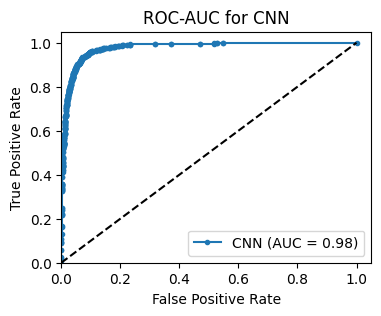

Whole AUC (Micro-average AUC): 0.98


In [22]:
class_labels = [0, 1, 2, 3, 4, 5, 6, 7]

y_test_bin = label_binarize(y_test, classes=class_labels)

y_pred_prob = model_cnn.predict(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_labels)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
plt.figure(figsize=(4, 3))
plt.plot(fpr["micro"], tpr["micro"], marker='o', markersize=3, linestyle='-', label='CNN (AUC = {:.2f})'.format(roc_auc["micro"]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC for CNN')
plt.legend(loc="lower right")
plt.show()

print("Whole AUC (Micro-average AUC): {:.2f}".format(roc_auc["micro"]))

Xception

In [23]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable=False
x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu')(x)

predictions = Dense(8, activation='softmax')(x)

model_x = Model(inputs=base_model.input, outputs=predictions)

model_x.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy','Precision','Recall', 'AUC'])

model_x.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ input_layer_4[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 55, 55,    │        512 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 55, 55,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 55, 55,    │          0 │ add[0][0]       

 Total params: 22,967,856 (87.62 MB)

 Trainable params: 22,913,328 (87.41 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [24]:
hist4 = model_x.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=25, batch_size=32, verbose=1)

Epoch 1/25


W0000 00:00:1716866906.576089     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - AUC: 0.9374 - Precision: 0.7880 - Recall: 0.6287 - accuracy: 0.7198 - loss: 0.8245

W0000 00:00:1716867009.098505     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


225/225 ━━━━━━━━━━━━━━━━━━━━ 182s 469ms/step - AUC: 0.9376 - Precision: 0.7883 - Recall: 0.6293 - accuracy: 0.7202 - loss: 0.8234 - val_AUC: 0.9440 - val_Precision: 0.7990 - val_Recall: 0.7650 - val_accuracy: 0.7825 - val_loss: 0.9071
Epoch 2/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 102s 453ms/step - AUC: 0.9920 - Precision: 0.9053 - Recall: 0.8850 - accuracy: 0.8942 - loss: 0.3011 - val_AUC: 0.9845 - val_Precision: 0.8460 - val_Recall: 0.8375 - val_accuracy: 0.8450 - val_loss: 0.4312
Epoch 3/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 102s 453ms/step - AUC: 0.9938 - Precision: 0.9162 - Recall: 0.9032 - accuracy: 0.9072 - loss: 0.2472 - val_AUC: 0.9859 - val_Precision: 0.8804 - val_Recall: 0.8462 - val_accuracy: 0.8612 - val_loss: 0.3999
Epoch 4/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 102s 452ms/step - AUC: 0.9956 - Precision: 0.9303 - Recall: 0.9165 - accuracy: 0.9224 - loss: 0.2117 - val_AUC: 0.9910 - val_Precision: 0.8995 - val_Recall: 0.8950 - val_accuracy: 0.8988 - val_loss: 0.2767
Epoch 5/25
225/225 ━━━━━━━━

In [25]:
predict=model_x.predict(X_test)
classes=np.argmax(predict,axis=1)
rounded_labels=np.argmax(y_test, axis=1)
print(classification_report(rounded_labels,classes))
cnf_matrix=confusion_matrix(rounded_labels,classes)
print(cnf_matrix)
plt.figure(figsize=(12, 8))

 2/25 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step

W0000 00:00:1716869495.675374     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step
              precision    recall  f1-score   support

           0       0.97      0.90      0.93       100
           1       0.91      0.96      0.94       100
           2       0.95      0.63      0.76       100
           3       0.95      0.96      0.96       100
           4       0.96      1.00      0.98       100
           5       0.73      0.96      0.83       100
           6       0.99      0.68      0.80       100
           7       0.76      0.99      0.86       100

    accuracy                           0.89       800
   macro avg       0.90      0.89      0.88       800
weighted avg       0.90      0.89      0.88       800

[[ 90   9   0   1   0   0   0   0]
 [  3  96   0   0   0   0   0   1]
 [  0   0  63   0   1  36   0   0]
 [  0   0   0  96   0   0   1   3]
 [  0   0   0   0 100   0   0   0]
 [  0   0   3   0   1  96   0   0]
 [  0   0   0   3   2   0  68  27]
 [  0   0   0   1   0   0   0  99]]


<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step


<Figure size 640x480 with 0 Axes>

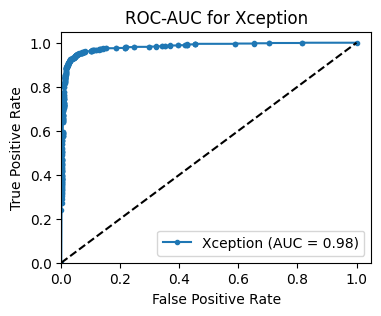

Whole AUC (Micro-average AUC): 0.98


In [26]:
class_labels = [0, 1, 2, 3, 4, 5, 6, 7]

y_test_bin = label_binarize(y_test, classes=class_labels)

y_pred_prob = model_x.predict(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_labels)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
plt.figure(figsize=(4, 3))
plt.plot(fpr["micro"], tpr["micro"], marker='o', markersize=3, linestyle='-', label='Xception (AUC = {:.2f})'.format(roc_auc["micro"]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC for Xception')
plt.legend(loc="lower right")
plt.show()

print("Whole AUC (Micro-average AUC): {:.2f}".format(roc_auc["micro"]))

DenseNet-201

In [27]:
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu')(x)

predictions = Dense(8, activation='softmax')(x)

model_d201 = Model(inputs=base_model.input, outputs=predictions)

model_d201.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy','Precision','Recall', 'AUC'])
model_d201.summary()

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer_5[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 20,297,288 (77.43 MB)

 Trainable params: 20,068,232 (76.55 MB)

 Non-trainable params: 229,056 (894.75 KB)

In [28]:
hist5 = model_d201.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=25, batch_size=32, verbose=1)

Epoch 1/25


W0000 00:00:1716869815.858523     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - AUC: 0.9356 - Precision: 0.7237 - Recall: 0.6326 - accuracy: 0.6798 - loss: 0.9229

W0000 00:00:1716869940.959212     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


225/225 ━━━━━━━━━━━━━━━━━━━━ 434s 569ms/step - AUC: 0.9357 - Precision: 0.7240 - Recall: 0.6330 - accuracy: 0.6802 - loss: 0.9217 - val_AUC: 0.8965 - val_Precision: 0.5915 - val_Recall: 0.5575 - val_accuracy: 0.5750 - val_loss: 1.6309
Epoch 2/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 111s 492ms/step - AUC: 0.9877 - Precision: 0.8668 - Recall: 0.8501 - accuracy: 0.8562 - loss: 0.3730 - val_AUC: 0.7929 - val_Precision: 0.5083 - val_Recall: 0.4975 - val_accuracy: 0.5075 - val_loss: 3.4285
Epoch 3/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 110s 489ms/step - AUC: 0.9922 - Precision: 0.8935 - Recall: 0.8816 - accuracy: 0.8879 - loss: 0.2954 - val_AUC: 0.9664 - val_Precision: 0.7724 - val_Recall: 0.7337 - val_accuracy: 0.7513 - val_loss: 0.6840
Epoch 4/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 110s 488ms/step - AUC: 0.9923 - Precision: 0.8955 - Recall: 0.8814 - accuracy: 0.8888 - loss: 0.2955 - val_AUC: 0.9082 - val_Precision: 0.6658 - val_Recall: 0.6575 - val_accuracy: 0.6612 - val_loss: 1.6158
Epoch 5/25
225/225 ━━━━━━━━

In [29]:
predict=model_d201.predict(X_test)
classes=np.argmax(predict,axis=1)
rounded_labels=np.argmax(y_test, axis=1)
print(classification_report(rounded_labels,classes))
cnf_matrix=confusion_matrix(rounded_labels,classes)
print(cnf_matrix)
plt.figure(figsize=(12, 8))

 2/25 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step

W0000 00:00:1716872584.461555     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 106ms/step
              precision    recall  f1-score   support

           0       0.86      0.96      0.91       100
           1       0.98      0.85      0.91       100
           2       0.86      0.71      0.78       100
           3       0.97      0.95      0.96       100
           4       0.99      0.98      0.98       100
           5       0.74      0.87      0.80       100
           6       0.92      0.83      0.87       100
           7       0.84      0.96      0.90       100

    accuracy                           0.89       800
   macro avg       0.89      0.89      0.89       800
weighted avg       0.89      0.89      0.89       800

[[96  2  0  0  0  0  1  1]
 [15 85  0  0  0  0  0  0]
 [ 0  0 71  0  0 29  0  0]
 [ 0  0  0 95  0  0  2  3]
 [ 0  0  0  0 98  2  0  0]
 [ 0  0 12  0  0 87  0  1]
 [ 0  0  0  3  1  0 83 13]
 [ 0  0  0  0  0  0  4 96]]


<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step


<Figure size 640x480 with 0 Axes>

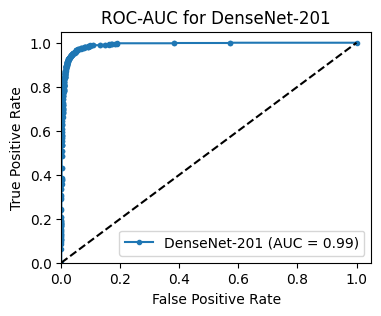

Whole AUC (Micro-average AUC): 0.99


In [30]:
class_labels = [0, 1, 2, 3, 4, 5, 6, 7]

y_test_bin = label_binarize(y_test, classes=class_labels)

y_pred_prob = model_d201.predict(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_labels)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
plt.figure(figsize=(4, 3))
plt.plot(fpr["micro"], tpr["micro"], marker='o', markersize=3, linestyle='-', label='DenseNet-201 (AUC = {:.2f})'.format(roc_auc["micro"]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC for DenseNet-201')
plt.legend(loc="lower right")
plt.show()

print("Whole AUC (Micro-average AUC): {:.2f}".format(roc_auc["micro"]))

Summarize

In [31]:
histories = [hist, hist2, hist3, hist4, hist5]
model_names = ['Efficient-Gastro', 'VGG19', 'CNN', 'Xception', 'DenseNet-201']

metrics_to_print = ['accuracy', 'precision', 'recall', 'auc']

metrics_dict = {model_name: {} for model_name in model_names}

for history, model_name in zip(histories, model_names):
    last_epoch_metrics = {
        key: value[-1] for key, value in history.history.items() if any(metric in key for metric in metrics_to_print) or key.startswith('val_')
    }
    metrics_dict[model_name] = last_epoch_metrics

metrics_df = pd.DataFrame(metrics_dict).T

print(metrics_df)


                  accuracy   val_AUC  val_Precision  val_Recall  val_accuracy  \
Efficient-Gastro  0.977361  0.972507       0.859473     0.85625       0.85875   
VGG19             0.992639  0.942396       0.852273     0.84375       0.85000   
CNN               0.869722  0.969995       0.804598     0.78750       0.79750   
Xception          0.985694  0.964061       0.887218     0.88500       0.88500   
DenseNet-201      0.977639  0.981992       0.893216     0.88875       0.88875   

                  val_loss  
Efficient-Gastro  0.591154  
VGG19             1.230067  
CNN               0.606778  
Xception          0.781412  
DenseNet-201      0.418084  


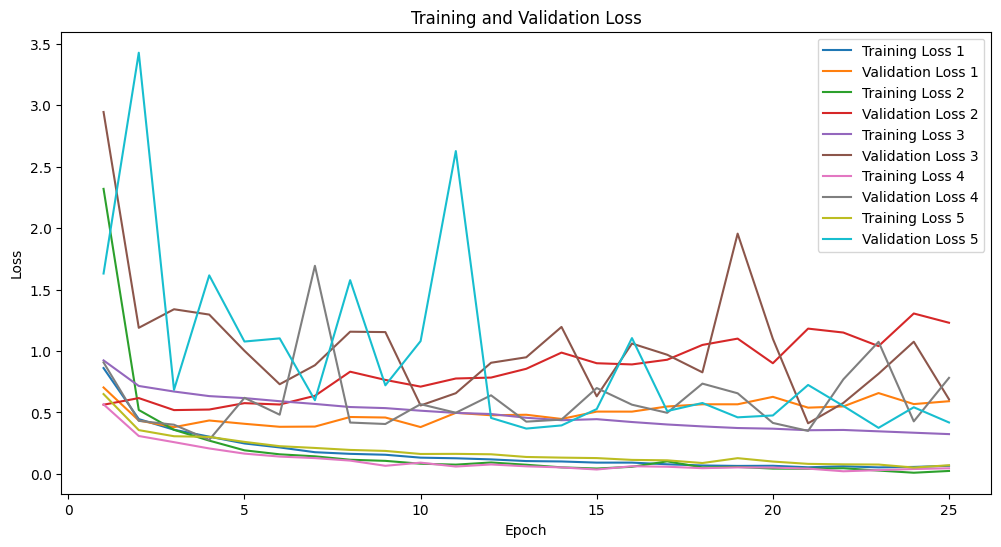

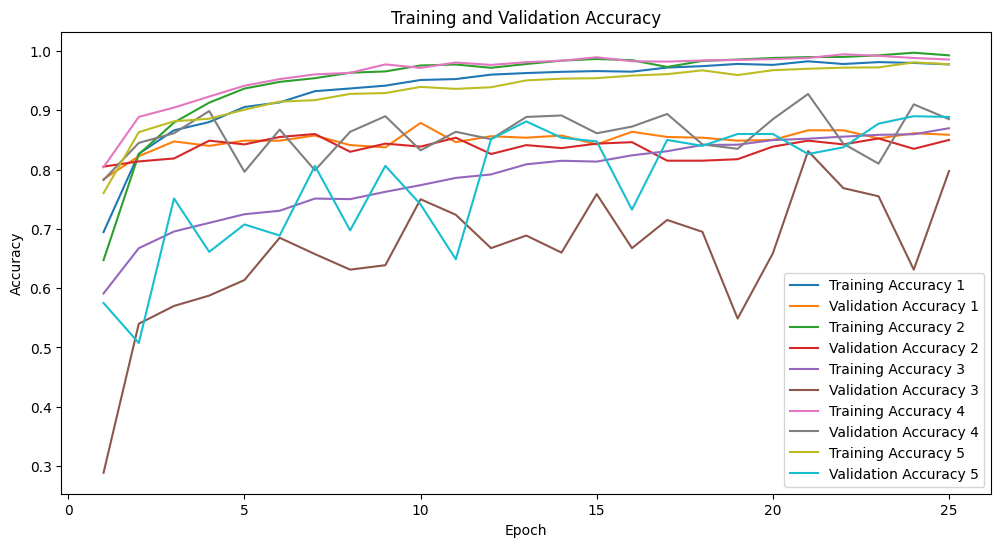

In [38]:
# Example history objects
histories = [hist, hist2, hist3, hist4, hist5]

# Plotting loss
plt.figure(figsize=(12, 6))
for i, history in enumerate(histories, start=1):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(train_loss) + 1)
    plt.plot(epochs, train_loss, label=f'Training Loss {i}')
    plt.plot(epochs, val_loss, label=f'Validation Loss {i}')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plotting accuracy
plt.figure(figsize=(12, 6))
for i, history in enumerate(histories, start=1):
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(train_acc) + 1)
    plt.plot(epochs, train_acc, label=f'Training Accuracy {i}')
    plt.plot(epochs, val_acc, label=f'Validation Accuracy {i}')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


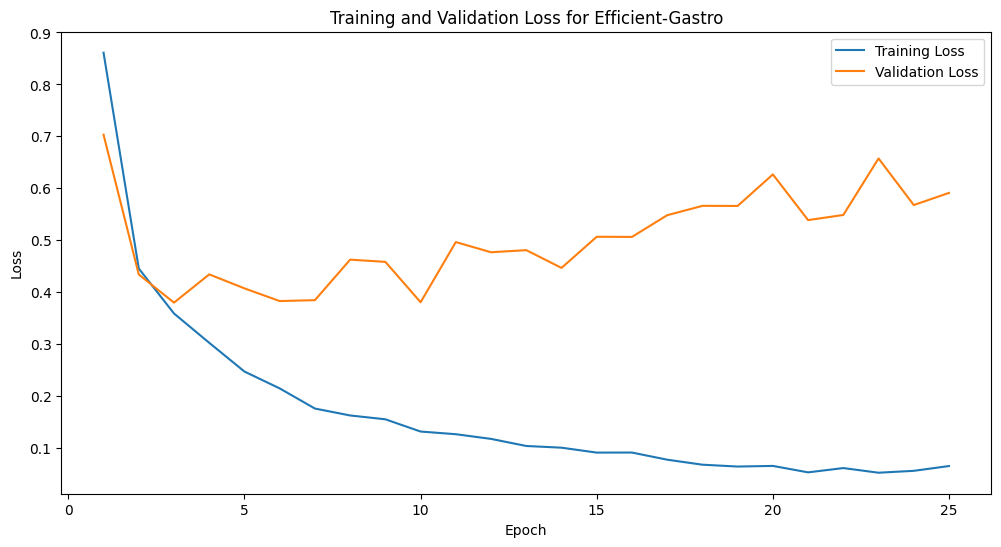

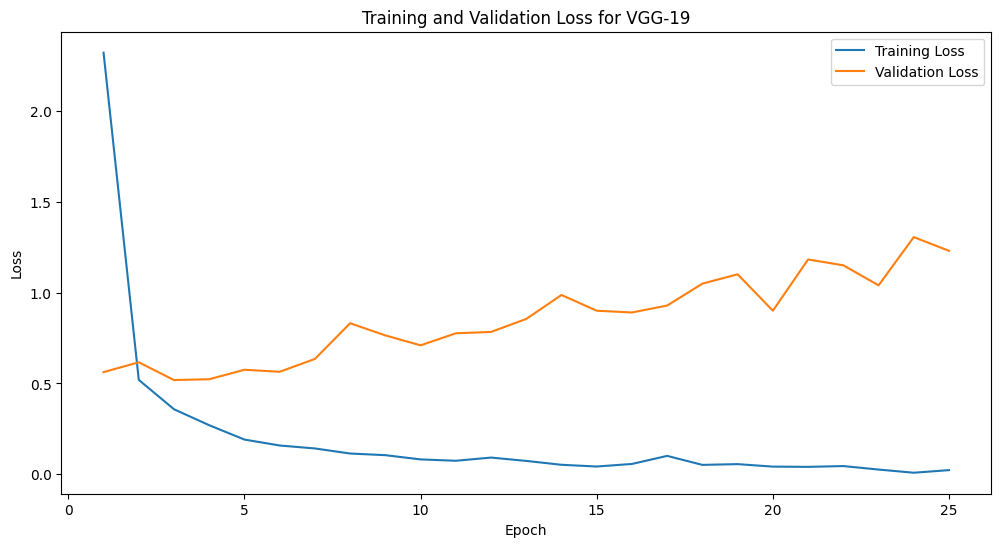

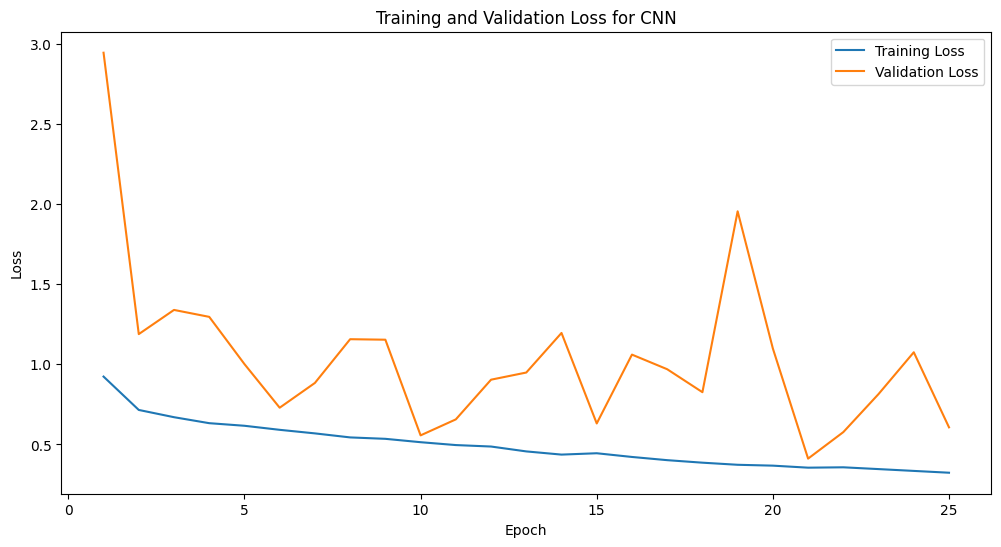

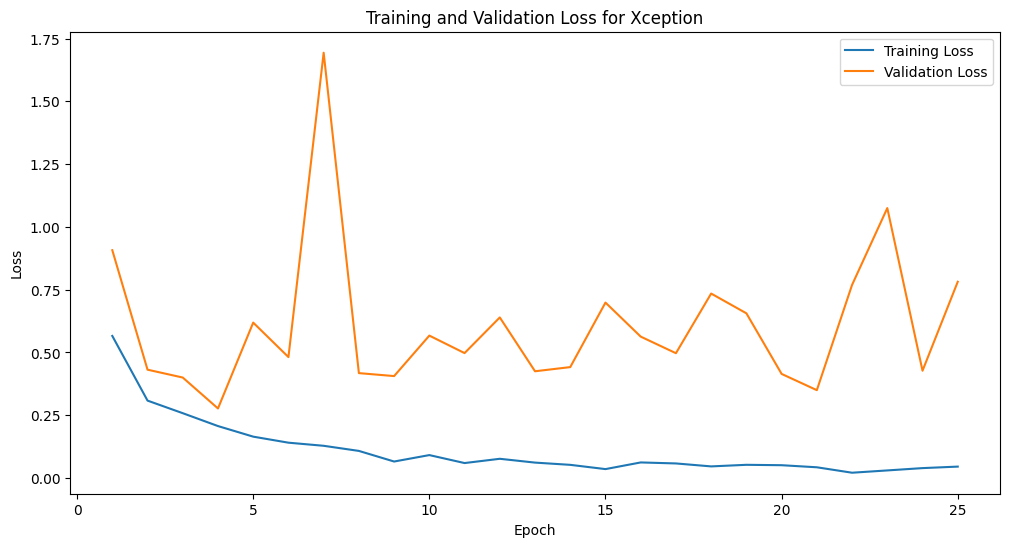

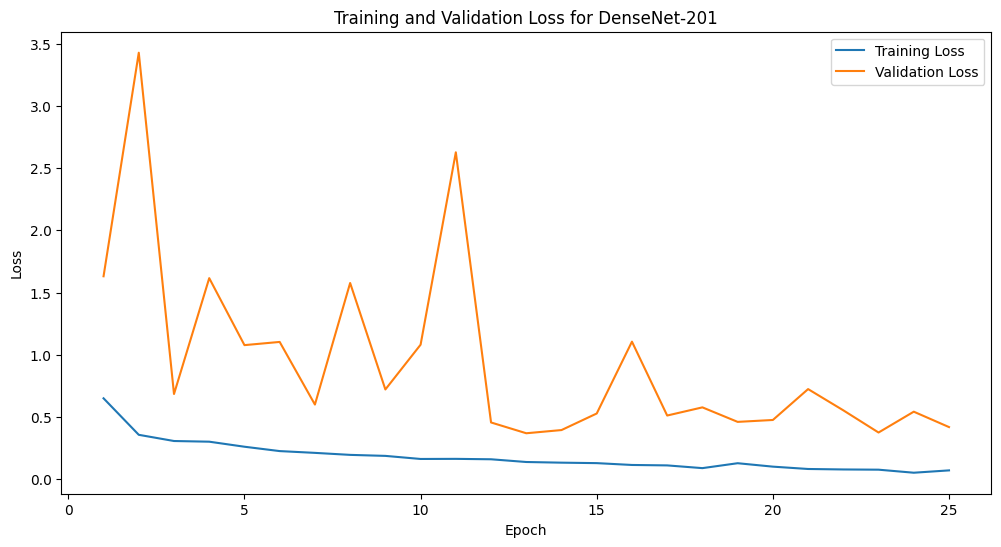

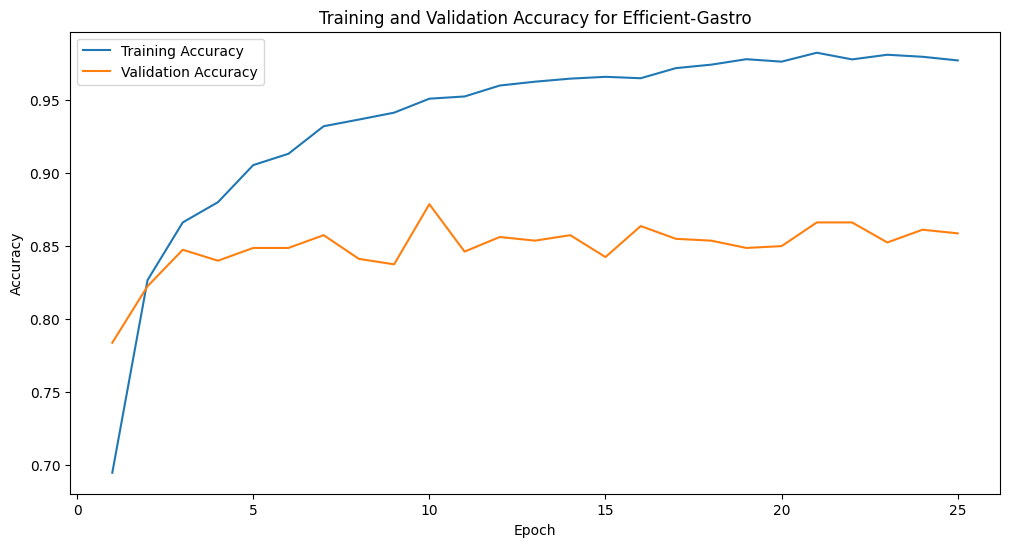

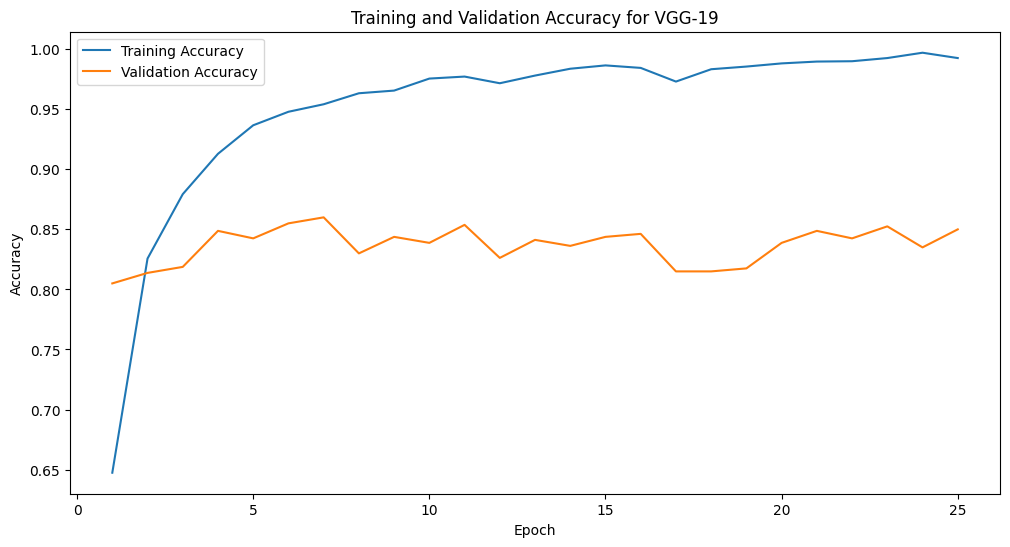

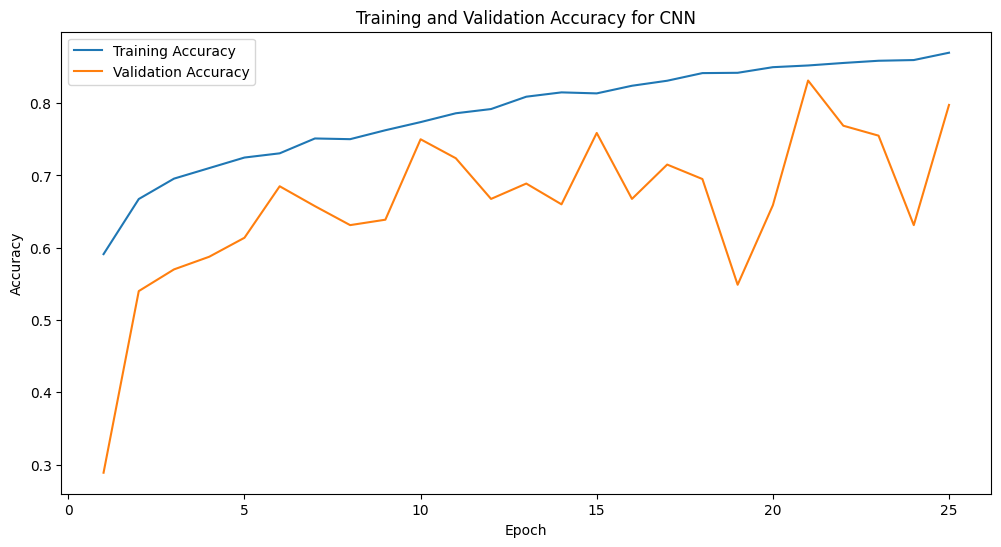

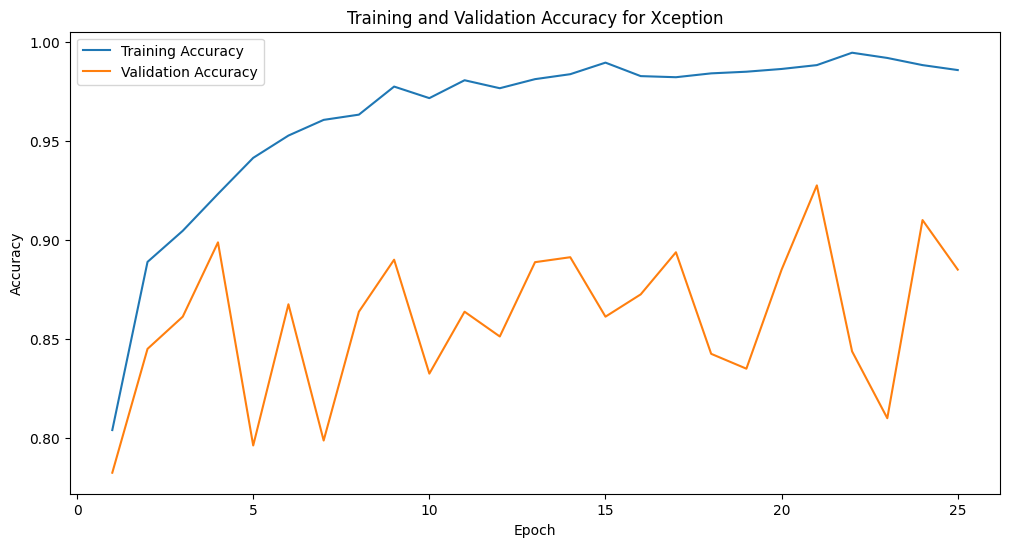

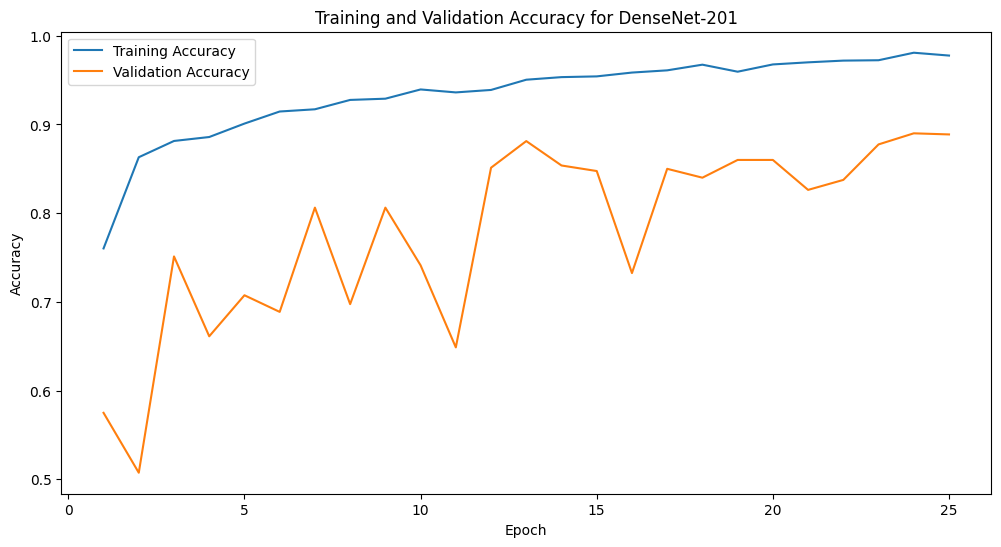

In [40]:
histories = [hist, hist2, hist3, hist4, hist5]
history_names = ['Efficient-Gastro', 'VGG-19', 'CNN', 'Xception', 'DenseNet-201']

for i, (history, name) in enumerate(zip(histories, history_names), start=1):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(train_loss) + 1)
    
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss for {name}')
    plt.legend()
    plt.show()

for i, (history, name) in enumerate(zip(histories, history_names), start=1):
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(train_acc) + 1)
    
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, train_acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Training and Validation Accuracy for {name}')
    plt.legend()
    plt.show()
